In [1]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.utils.track_utils import RaceTrack, CentreLine


from f1tenth_benchmarks.data_tools.general_plotting.plot_trajectory_analysis import plot_trajectory_analysis
from f1tenth_benchmarks.data_tools.general_plotting.plot_raceline_tracking import plot_raceline_tracking

from f1tenth_benchmarks.data_tools.plotting_utils import *
from f1tenth_benchmarks.run_scripts.run_functions import *
import numpy as np


if os.getcwd().split('/')[-1] == 'debugging':
    os.chdir('../..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/Debugging/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_benchmarks


# DRL

In [2]:

seeds = [12, 13, 14]
rewards = ["Progress", "CTH", "TAL"]
train_maps = ["mco", "gbr", "esp", "aut"]

total_training_steps = 50000
resampled_xs = np.linspace(0, total_training_steps, 50000)

avg_training_data = {}
min_training_data = {}
max_training_data = {}
avg_reward_data = {}
min_reward_data = {}
max_reward_data = {}
downsampled_xs = np.linspace(0, total_training_steps, 1000)

training_data = {}
for train_map in train_maps:
    for reward in rewards:
        temp_progress_data = []
        temp_reward_data = []
        for seed in seeds:
            test_id = f"TD3_{reward}_{seed}_{train_map}"

            root_path = f"Logs/EndToEnd/RawData_{test_id}/"
            results = pd.read_csv(root_path + f"TrainingData_{test_id}.csv")
            steps = results["Steps"]
            progresses = results["Progress"]*100

            resampled_progress = np.interp(resampled_xs, steps, progresses)
            temp_progress_data.append(resampled_progress)

            reward_hsitory = np.load(root_path + "RewardHistory.npy")
            resampled_rewards = np.interp(resampled_xs, steps, reward_hsitory)
            temp_reward_data.append(resampled_rewards)

        avg_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.mean(temp_progress_data, axis=0))
        min_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.min(temp_progress_data, axis=0))
        max_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.max(temp_progress_data, axis=0))

        avg_reward_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.mean(temp_reward_data, axis=0))
        min_reward_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.min(temp_reward_data, axis=0))
        max_reward_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.max(temp_reward_data, axis=0))

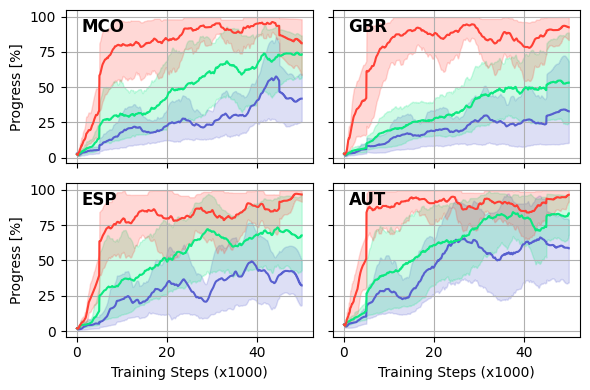

In [3]:

colors = [periwinkle, minty_green, red_orange]
period = 100

fig, ax = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey=True)
for i, train_map in enumerate(train_maps):
    for j, reward in enumerate(rewards):
        ys = avg_training_data[f"{reward}_{train_map}"]
        ys = true_moving_average(ys, period)
        ax[int(i/2), i%2].plot(downsampled_xs/1e3, ys, label=reward, color=colors[j])
        ys_min = true_moving_average(min_training_data[f"{reward}_{train_map}"], period)
        ys_max = true_moving_average(max_training_data[f"{reward}_{train_map}"], period)
        ax[int(i/2), i%2].fill_between(downsampled_xs/1e3, ys_min, ys_max, alpha=0.2, color=colors[j])

    ax[int(i/2), i%2].text(1, 89, f"{train_map.upper()}", fontdict={"fontsize": 12, "fontweight": "bold"})
    ax[1, i%2].set_xlabel("Training Steps (x1000)")
    ax[int(i/2), 0].set_ylabel("Progress [%]")
    ax[int(i/2), i%2].grid()

plt.tight_layout()

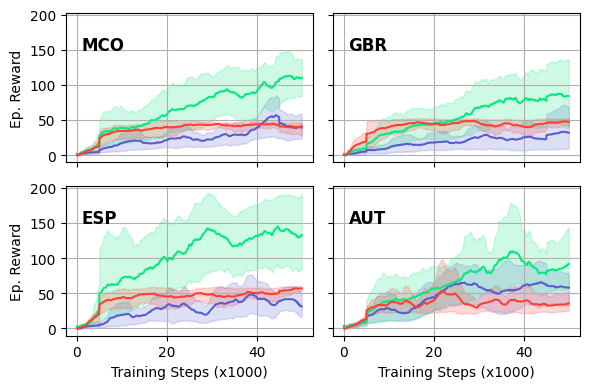

In [4]:

colors = [periwinkle, minty_green, red_orange]
period = 100

fig, ax = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey=True)
for i, train_map in enumerate(train_maps):
    for j, reward in enumerate(rewards):
        ys = avg_reward_data[f"{reward}_{train_map}"]
        ys = true_moving_average(ys, period)
        ax[int(i/2), i%2].plot(downsampled_xs/1e3, ys, label=reward, color=colors[j])
        ys_min = true_moving_average(min_reward_data[f"{reward}_{train_map}"], period)
        ys_max = true_moving_average(max_reward_data[f"{reward}_{train_map}"], period)
        ax[int(i/2), i%2].fill_between(downsampled_xs/1e3, ys_min, ys_max, alpha=0.2, color=colors[j])

    ax[int(i/2), i%2].text(1, 150, f"{train_map.upper()}", fontdict={"fontsize": 12, "fontweight": "bold"})
    ax[1, i%2].set_xlabel("Training Steps (x1000)")
    ax[int(i/2), 0].set_ylabel("Ep. Reward")
    ax[int(i/2), i%2].grid()

plt.tight_layout()

In [7]:
summary_df = pd.read_csv("Logs/Summary.csv")

map_list = ["aut", "esp", "gbr", "mco"]

avg_data = {}
min_data = {}
max_data = {}
for i, reward in enumerate(rewards):
    for train_map in map_list:
        test_ids = [f"TD3_{reward}_{seed}_{train_map}" for seed in seeds]
        mini_df = summary_df.loc[summary_df.TestID.isin(test_ids)].drop(columns=["TestID", "Vehicle", "VehicleID"])
        avg_data[f"{reward}_{train_map}"] = mini_df.groupby("MapName").mean()

avg_data = pd.concat(avg_data).reset_index().fillna(0)
avg_data["Reward"] = avg_data["level_0"].apply(lambda x: x.split("_")[0])
avg_data["TrainMap"] = avg_data["level_0"].apply(lambda x: x.split("_")[1])
avg_data = avg_data.drop(columns=["level_0", "StdTime"])
avg_data = avg_data.rename(columns={"MapName": "TestMap"})

# print(avg_data)
avg_data.to_csv("Logs/drl_avg_data.csv", index=False)



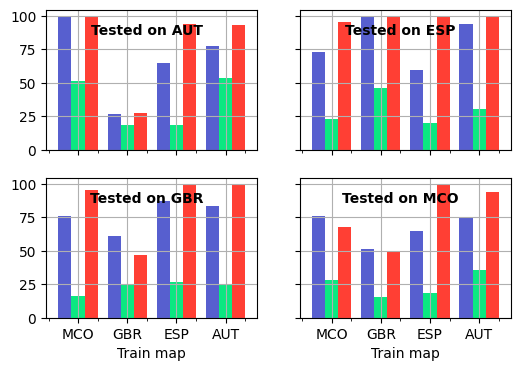

<Figure size 600x400 with 0 Axes>

In [16]:

summary_df = pd.read_csv("Logs/drl_avg_data.csv")

map_list = ["aut", "esp", "gbr", "mco"]

fig, ax = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey=True)

fig = plt.figure(figsize=(6, 4))

xs = np.arange(len(map_list))
width = 0.8
for i, test_map in enumerate(map_list):
    grouped_df = summary_df.loc[summary_df.TestMap == test_map]
    grouped_df = grouped_df[["AvgProgress", "TrainMap", "Reward"]]
    grouped_df["AvgProgress"] = grouped_df["AvgProgress"]*100
    grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgProgress")
    # print(grouped_df)
    grouped_df = grouped_df.reset_index("TrainMap")
    grouped_df.plot.bar(ax=ax[int(i/2), i%2], color=colors, width=width, position=1, legend=False)

    axs = ax[int(i/2), i%2]
    axs.set_xticks(xs - width/2)
    axs.set_xticklabels([x.upper() for x in train_maps], rotation=0)
    axs.set_xlabel(f"Train map")
    # ax[int(i/2), i%2].set_title(f"{test_map.upper()}")
    axs.text(1, 89, f"Tested on {test_map.upper()}", ha="center", fontdict={"fontsize": 10, "fontweight": "bold"}, va="center")
    axs.grid()

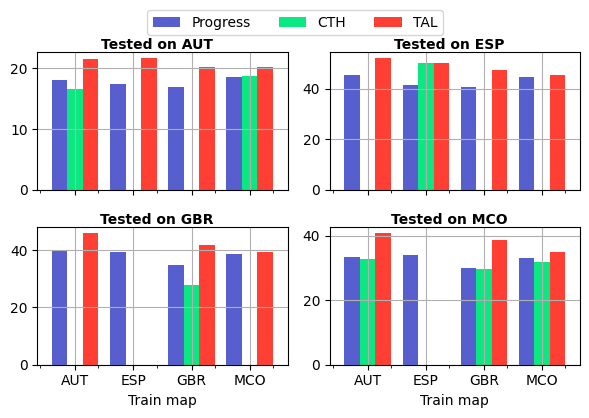

In [18]:

summary_df = pd.read_csv("Logs/drl_avg_data.csv")

map_list = ["aut", "esp", "gbr", "mco"]

fig, ax = plt.subplots(2, 2, figsize=(6, 4), sharex=True)

xs = np.arange(len(map_list))
width = 0.8
for i, test_map in enumerate(map_list):
    grouped_df = summary_df.loc[summary_df.TestMap == test_map] 
    grouped_df = grouped_df[["AvgTime", "TrainMap", "Reward"]]
    max_time = grouped_df.AvgTime.max()
    grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgTime")
    # print(grouped_df)
    grouped_df = grouped_df.reset_index("TrainMap")
    grouped_df.plot.bar(ax=ax[int(i/2), i%2], color=colors, width=width, position=1, legend=False)

    ax[int(i/2), i%2].set_xticks(xs - width/2)
    ax[int(i/2), i%2].set_xticklabels([x.upper() for x in map_list], rotation=0)
    ax[int(i/2), i%2].set_xlabel(f"Train map")
    # ax[int(i/2), i%2].set_title(f"{test_map.upper()}")
    ax[int(i/2), i%2].text(1, max_time * 1.1, f"Tested on {test_map.upper()}", ha="center", fontdict={"fontsize": 10, "fontweight": "bold"}, va="center")
    ax[int(i/2), i%2].grid()

fig.legend(["Progress", "CTH", "TAL"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()

## Trajectories

In [12]:
planner_name = "EndToEnd"
seed = 13
train_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
frequency = 25
n_laps = 5


lap_dfs = []
for i, test_id in enumerate(test_ids):
    for m, map_name in enumerate(map_list):
        for lap_n in range(n_laps):
            data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
            df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
            df.steer_a = df.steer_a * 180 / np.pi
            df.yaw = df.yaw * 180 / np.pi
            df.slip = df.slip.abs() * 180 / np.pi

            el_lengths = np.linalg.norm(np.diff(data[:, :2], axis=0), axis=1)
            s_old = np.insert(np.cumsum(el_lengths), 0, 0)
            s_interp = np.linspace(0, np.sum(el_lengths), 1000)
            x_interp = np.interp(s_interp, s_old, data[:, 0])
            y_interp = np.interp(s_interp, s_old, data[:, 1])
            interp_path = np.stack([x_interp, y_interp], axis=1)
            el_lengths = np.linalg.norm(np.diff(interp_path, axis=0), axis=1)
            psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(interp_path, el_lengths, False)
            kappa_original_s = np.interp(s_old, s_interp, kappa)
            df["curvature"] = np.abs(kappa_original_s) * 180 / np.pi
            # df["curvature"] = np.abs(kappa) * 180 / np.pi
            df["d_steer"] = df.steer_a.diff().abs() * frequency
            df["lap_n"] = lap_n
            df["TestID"] = test_id
            df["map_name"] = map_name

            # data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/TrackingAccuracy_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
            # # print(data[:4, :])
            # df["ct_error"] = np.abs(data[:, 1])
            # df["speed_error"] = np.abs(data[:, 4])
            # df["raceline_speed"] = np.abs(data[:, 5])

            lap_dfs.append(df)


lap_df = pd.concat(lap_dfs)
lap_df.dropna(inplace=True)
# lap_df.loc[lap_df["progress"] < 0.05, "speed_error"] = 0
# lap_df.loc[lap_df["progress"] < 0.02, "curvature"] = 0
print(lap_df.head())


          x    y  steer     speed  yaw  yaw_rate      slip    steer_a  \
1  0.003352  0.0  0.000  0.288383  0.0  0.000000  0.000000   0.000000   
2  0.019617  0.0  0.000  0.591440  0.0  0.000000  0.000000   0.000000   
3  0.047168  0.0  0.000  0.840838  0.0  0.000000  0.000000   0.000000   
4  0.084005  0.0  0.000  1.046078  0.0  0.000000  0.000000  13.908064   
5  0.131554  0.0  0.064  1.426478  0.0  0.059111  0.201886  13.267402   

    speed_a  progress  curvature     d_steer  lap_n               TestID  \
1  2.000000       0.0   0.000000    0.000000      0  TD3_Progress_13_mco   
2  2.000000       0.0   0.000000    0.000000      0  TD3_Progress_13_mco   
3  2.000000       0.0   0.000000    0.000000      0  TD3_Progress_13_mco   
4  7.505400       0.0   0.000000  347.701606      0  TD3_Progress_13_mco   
5  7.448153       0.0  41.888995   16.016555      0  TD3_Progress_13_mco   

  map_name  
1      aut  
2      aut  
3      aut  
4      aut  
5      aut  


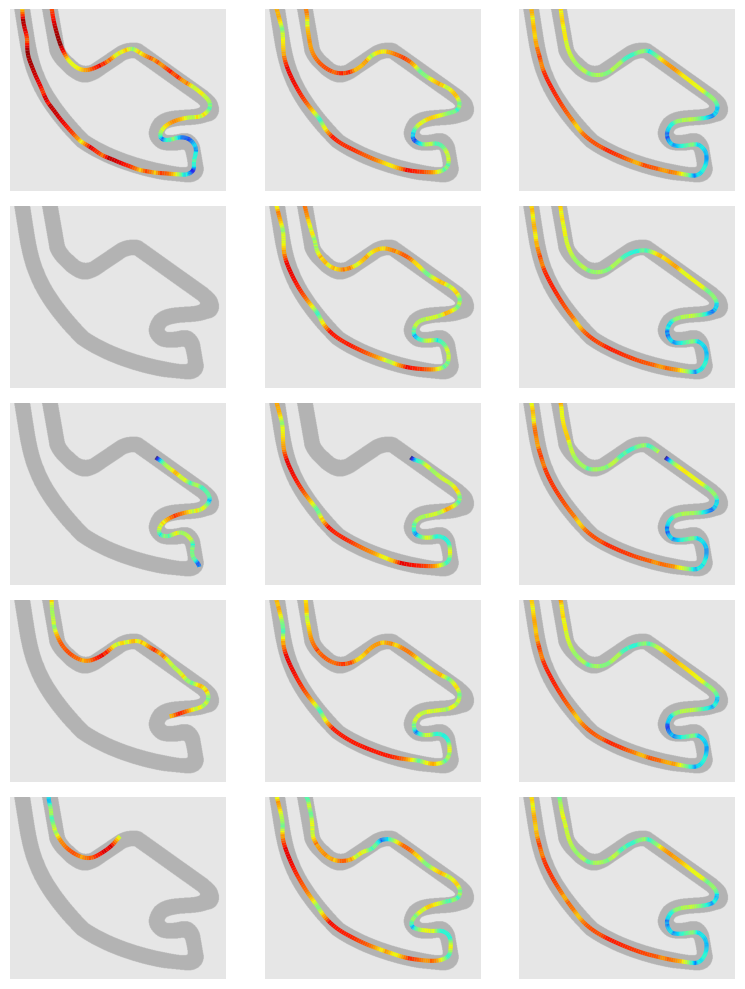

In [13]:
plot_map = "mco"
map_data = MapData(plot_map)

fig, axs = plt.subplots(5, len(test_ids), figsize=(8, 10), sharex=True, sharey=True)
for j in range(5):
    for i in range(len(test_ids)):
        plt.sca(axs[j, i])
        map_data.plot_map_img()

        df = lap_df[lap_df["TestID"] == test_ids[i]]
        df = df[df["map_name"] == plot_map]
        df = df[df['lap_n'] == j]

        xs, ys = map_data.xy2rc(df.x, df.y)
        pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
        segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
        norm = plt.Normalize(1, 8)
        lc = LineCollection(segments, cmap='jet', norm=norm)
        lc.set_array(df.speed.values)
        lc.set_linewidth(3)
        line = plt.gca().add_collection(lc)
        
        plt.axis('off')
        axs[j, i].set_aspect('equal')
        plt.xlim(600, 1110)
        plt.ylim(70, 500)
        # plt.title(test_ids[i])

    # ax = plt.gca()
    # cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
    # plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
    plt.tight_layout()

# plt.savefig(f"{save_path}speed_trajectories_{map_name}.pdf", bbox_inches='tight')